# Planning

In [1]:
# distance function
import os
os.chdir('C:/Users/clack/Projects/nwm')

import torch
import torch.nn as nn
from experiment.vae import Encoder

class DistancePredictor(nn.Module):
  def __init__(self, bottleneck_channels: int, hidden_dim: int, classes: int) -> None:
    super().__init__()
    self.convolutional_layers = Encoder(
      block_config_str='8x6,8d2,8t4,4x4,4d4,4t1,1x4',
      channel_config_str='8:256,4:256,1:512',
      bottleneck_channels=bottleneck_channels,
      image_channels=8
    )
    self.mlp = nn.Sequential(
      nn.ReLU(),
      nn.Linear(bottleneck_channels, hidden_dim),
      nn.ReLU(),
      nn.Linear(hidden_dim, classes)
    )

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    convolved, _ = self.convolutional_layers(x)
    return self.mlp(convolved.reshape(x.shape[0], -1))

def make_distance_predictor():
  return DistancePredictor(32, 128, 64)

In [2]:
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
from typing import Callable, List, Tuple


transform = transforms.Compose([
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
def denormalize(tensor, mean=0.5, std=0.5):
    return tensor * std + mean

class OnDemandDataset(torchvision.datasets.VisionDataset):
  def __init__(self, size: int, sample: Callable[[], torch.Tensor], transform = None):
    super().__init__(transform=transform)
    self.size = size
    self.sample = sample

  def __len__(self):
    return self.size
  
  def __getitem__(self, _) -> torch.Tensor:
    return self.transform(self.sample()) if self.transform else self.sample()
  
from experiment.nav2d import Topo

def sample():
  camera_size = 64
  while True:
    state = Topo.random(avoid_wall_start=True)
    # sample a target position
    target_position = None
    tries = 10
    while target_position is None or state.terrain[
      target_position.round().astype(np.int32)[1],
      target_position.round().astype(np.int32)[0]
    ] >= state.wall_height:
      if tries == 0:
        break
      tries -= 1
      
      # offset_upper_bound = state.terrain_size // 2 - camera_size // 2
      offset_upper_bound = 64
      # disproportionately sample small offsets
      biased_upper_bound = offset_upper_bound# np.random.rand() * offset_upper_bound
      target_position = state.position + biased_upper_bound * (np.random.rand(2) * 2 - 1)
    if target_position is None:
      continue

    distance = shortest_path(state, state.position, target_position, distance_only=True)
    if distance is None:
      continue
    assert isinstance(distance, float)
    if distance > offset_upper_bound:
      continue

    image1 = state.render(camera_size)
    image1 = transform(torch.from_numpy(image1).permute(2, 0, 1).to(torch.float32))

    state.position = target_position
    image2 = state.render(camera_size)
    image2 = transform(torch.from_numpy(image2).permute(2, 0, 1).to(torch.float32))
  
    return image1, image2, torch.tensor(distance, dtype=torch.float32)


import heapq


def shortest_path(
  state: Topo, start: np.ndarray, end: np.ndarray, max_distance: float | None = None, distance_only: bool = False, max_exploration: int = 8000
) -> Tuple[List[np.ndarray], float] | float | None:
  start_block = start.round().astype(np.uint32)
  end_block = end.round().astype(np.uint32)

  if state.terrain[start_block[1], start_block[0]] >= state.wall_height:
    return None
  if state.terrain[end_block[1], end_block[0]] >= state.wall_height:
    return None
  
  if max_distance is None:
    max_distance = float((np.abs(end_block - start_block).sum() * 4).item())


  edges = np.array(
    [np.array([0, 1]), np.array([1, 0]), np.array([0, -1]), np.array([-1, 0])]
    + [np.array([1, 1]), np.array([1, -1]), np.array([-1, 1]), np.array([-1, -1])]
  )
  edge_lengths = np.array([1] * 4 + [2**0.5] * 4)

  def heuristic(pos):
    return np.linalg.norm(pos - end_block)

  distance = np.full((state.terrain_size, state.terrain_size), np.inf, dtype=np.float32)
  distance[start_block[1], start_block[0]] = 0

  shortest_distance_found = max_distance
  visited = np.zeros((state.terrain_size, state.terrain_size), dtype=bool)
  visited_count = 0
  heads = [(heuristic(start_block), 0.0, tuple(start_block))]
  while heads:
    _, distance_from_start, head_tuple = heapq.heappop(heads)
    head = np.array(head_tuple, dtype=np.uint32)
    
    if visited[head[1], head[0]]:
      continue
    visited[head[1], head[0]] = True
    visited_count += 1
    if visited_count > max_exploration:
      return None
    
    if np.equal(head, end_block).all():
      shortest_distance_found = distance_from_start
      break

    if distance_from_start >= shortest_distance_found:
      continue

    neighbors = head[None, :] + edges
    out_of_bounds = (neighbors < 0).any(-1) | (neighbors >= state.terrain_size).any(-1)
    neighbors = neighbors[~out_of_bounds]

    estimated_neighbor_distances = distance_from_start + edge_lengths[~out_of_bounds]
    dead_end = (
      (state.terrain[neighbors[:, 1], neighbors[:, 0]] >= state.wall_height)
      | (estimated_neighbor_distances >= distance[neighbors[:, 1], neighbors[:, 0]])
      | (estimated_neighbor_distances > max_distance)
    )
    neighbors = neighbors[~dead_end]
    estimated_neighbor_distances = estimated_neighbor_distances[~dead_end]
    
    distance[neighbors[:, 1], neighbors[:, 0]] = estimated_neighbor_distances
    for neighbor, dist in zip(neighbors, estimated_neighbor_distances):
      heapq.heappush(heads, (dist + heuristic(neighbor), dist, tuple(neighbor)))

  if shortest_distance_found == max_distance:
    return None

  if distance_only:
    return shortest_distance_found
  # reconstruct a shortest path
  path = [end_block]
  while not np.equal(path[-1], start_block).all():
    neighbors = [path[-1] + edge for edge in edges]
    valid_neighbors = [n for n in neighbors if 0 <= n[0] < state.terrain_size and 0 <= n[1] < state.terrain_size]
    neighbor_closest_to_start = valid_neighbors[np.argmin(np.array([distance[neighbor[1], neighbor[0]] for neighbor in valid_neighbors]))]
    path.append(neighbor_closest_to_start)
  return list(reversed(path)), shortest_distance_found


def nav2d_dataset(size: int):
  return OnDemandDataset(
    size=size,
    sample=sample,
    # transform=transform
  )
# trainloader = torch.utils.data.DataLoader(nav2d_dataset(5000), batch_size=64, shuffle=True)
testloader = torch.utils.data.DataLoader(nav2d_dataset(1000), batch_size=64, shuffle=True)


def smooth_labels(num_classes: int, decay: float, logarithmic_march: float = 1.0, iterations: int = 10) -> torch.Tensor:
  # b^num_classes = decay * logarithmic_march
  # b = (decay * logarithmic_march)^1/num_classes
  labels = torch.eye(num_classes)
  base = logarithmic_march ** (1 / (num_classes - 1))
  decay_vector = decay * torch.pow(torch.tensor(base), torch.arange(num_classes)).unsqueeze(1)
  for _ in range(iterations):
    transfer = labels * decay_vector
    labels -= transfer
    right_transfer = transfer.roll(1, dims=0) / 2
    right_transfer[-1] += right_transfer[0]
    right_transfer[0] = 0

    left_transfer = transfer.roll(-1, dims=0) / 2
    left_transfer[0] += left_transfer[-1]
    left_transfer[-1] = 0
    labels += right_transfer + left_transfer
  pileup = labels.max(-1).values > labels.max(-1).values.roll(1)
  pileup[0] = False
  while pileup.any():
    transfer = labels * decay_vector
    labels[pileup] -= transfer[pileup]
    right_transfer = transfer.roll(1, dims=0) / 2
    right_transfer[-1] += right_transfer[0]
    right_transfer[0] = 0

    left_transfer = transfer.roll(-1, dims=0) / 2
    left_transfer[0] += left_transfer[-1]
    left_transfer[-1] = 0
    labels[pileup] += (right_transfer + left_transfer)[pileup]
    
    pileup = labels.max(-1).values > labels.max(-1).values.roll(1)
    pileup[0] = False
  # labels /= labels.sum(-1)
  return labels

tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0003, 0.0029, 0.0121, 0.0332, 0.0673, 0.1074, 0.1442, 0.1686, 0.1815,
        0.1855])

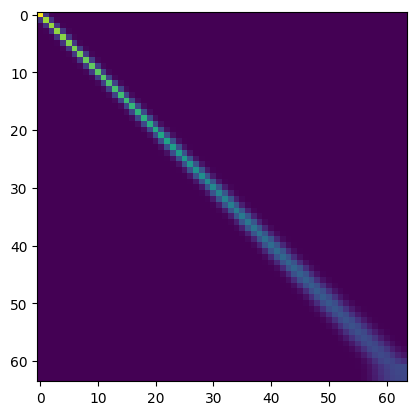

In [8]:
import matplotlib.pyplot as plt
labels = smooth_labels(64, 0.05, iterations=6, logarithmic_march=16)
# labels[-4] = 0
plt.imshow(labels)
# plt.plot(smooth_labels(64, 0.05, iterations=40, logarithmic_march=16)[63])
labels[63]

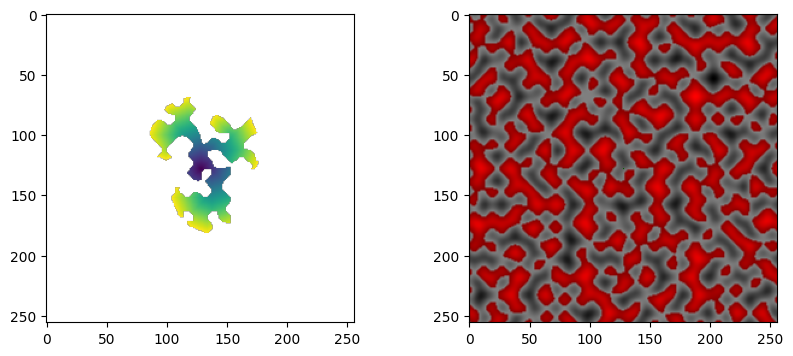

In [9]:
import heapq

import matplotlib.pyplot as plt
from tqdm import tqdm

def distance_map(
  state: Topo, start: np.ndarray, max_distance: float, forbidden_margin: int = 0
) -> np.ndarray:
  start_block = start.round().astype(np.uint32)
  
  distance = np.full((state.terrain_size, state.terrain_size), np.inf, dtype=np.float32)
  distance[start_block[1], start_block[0]] = 0

  edges = np.array(
    [np.array([0, 1]), np.array([1, 0]), np.array([0, -1]), np.array([-1, 0])]
    + [np.array([1, 1]), np.array([1, -1]), np.array([-1, 1]), np.array([-1, -1])]
  )
  edge_lengths = np.array([1] * 4 + [2**0.5] * 4)

  visited = np.zeros((state.terrain_size, state.terrain_size), dtype=bool)
  heads = [(0.0, tuple(start_block))]
  
  while heads:
    distance_from_start, head_tuple = heapq.heappop(heads)
    head = np.array(head_tuple, dtype=np.uint32)
    
    if visited[head[1], head[0]]:
      continue
    visited[head[1], head[0]] = True

    neighbors = head[None, :] + edges
    out_of_bounds = (neighbors < forbidden_margin).any(-1) | (neighbors >= state.terrain_size - forbidden_margin).any(-1)
    neighbors = neighbors[~out_of_bounds]

    estimated_neighbor_distances = distance_from_start + edge_lengths[~out_of_bounds]
    dead_end = (
      (state.terrain[neighbors[:, 1], neighbors[:, 0]] >= state.wall_height)
      | (estimated_neighbor_distances >= distance[neighbors[:, 1], neighbors[:, 0]])
      | (estimated_neighbor_distances > max_distance)
    )
    neighbors = neighbors[~dead_end]
    estimated_neighbor_distances = estimated_neighbor_distances[~dead_end]
    
    distance[neighbors[:, 1], neighbors[:, 0]] = estimated_neighbor_distances
    for neighbor, dist in zip(neighbors, estimated_neighbor_distances):
      heapq.heappush(heads, (dist, tuple(neighbor)))

  return distance


class TrajectoryDistanceSamplingDataset(torch.utils.data.Dataset):
  def __init__(self, size: int, samples_per_state: int, max_distance: int):
    super().__init__()
    self.size = size
    self.samples_per_state = samples_per_state
    self.max_distance = max_distance
    self.current_state = Topo.random()
    self.current_state_dist_map = distance_map(
      self.current_state,
      self.current_state.position,
      self.max_distance,
      forbidden_margin=96
    )
    self.reachable_positions = np.argwhere(~np.isinf(self.current_state_dist_map))
    self.start_image = self.current_state.render(64)
    self.current_state_sample_count = 0

  def __len__(self):
    return self.size
  
  def __getitem__(self, _) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
    if self.current_state_sample_count == self.samples_per_state:
      self.current_state_sample_count = 0
      self.current_state = Topo.random()
      self.current_state_dist_map = distance_map(
        self.current_state,
        self.current_state.position,
        self.max_distance,
        forbidden_margin=96
      )
      self.reachable_positions = np.argwhere(~np.isinf(self.current_state_dist_map))
      self.start_image = self.current_state.render(64)
    target_position = self.reachable_positions[np.random.randint(0, len(self.reachable_positions))]
    self.current_state.position = np.array([target_position[1], target_position[0]], dtype=np.float32)
    target_image = self.current_state.render(64)
    distance = self.current_state_dist_map[target_position[0], target_position[1]]
    return (
      transform(torch.from_numpy(self.start_image).permute(2, 0, 1).to(torch.float32)),
      transform(torch.from_numpy(target_image).permute(2, 0, 1).to(torch.float32)),
      torch.tensor(distance)
    )
  
class PresampledDataset(torch.utils.data.Dataset):
  def __init__(self, dataset: torch.utils.data.Dataset) -> None:
    super().__init__()
    self.dataset = tqdm([sample for sample in dataset], desc='Preloading dataset')

  def __len__(self):
    return len(self.dataset)
  
  def __getitem__(self, index: int):
    return self.dataset[index]
  
def new_dataloader(size: int, max_distance: int = 64):
  return torch.utils.data.DataLoader(
    # PresampledDataset(
    (
      TrajectoryDistanceSamplingDataset(size, samples_per_state=16, max_distance=max_distance)
    ),
    batch_size=64,
    shuffle=True
  )

state = Topo.random()
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].imshow(distance_map(state, state.position, 64, forbidden_margin=32))
axes[1].imshow(state.render(256))

tensor([27.3848])


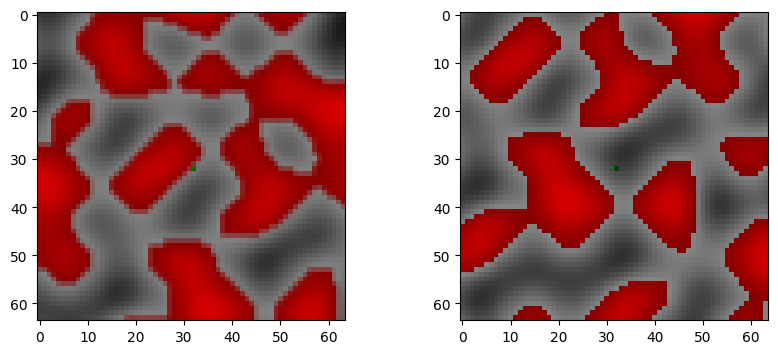

In [319]:
for image1, image2, distance in new_dataloader(1):
  fig, axes = plt.subplots(1, 2, figsize=(10, 4))
  axes[0].imshow(denormalize(image1[0].permute(1, 2, 0)))
  axes[1].imshow(denormalize(image2[0].permute(1, 2, 0)))
  print(distance)
  

In [16]:
import glob
import json
from pathlib import Path
from tqdm import tqdm

from experiment.vae import make_vae

SAVE_DIR = Path('checkpoints/distance/v6-slowcurr')
os.makedirs(SAVE_DIR, exist_ok=True)
torch.cuda.empty_cache()
device = 'cuda'
vae = make_vae().to(device)
vae.load_state_dict(torch.load('checkpoints/vae/topo/check1049.pt'))
vae.eval()
for param in vae.parameters():
  param.requires_grad = False
distance_predictor = make_distance_predictor().to(device)


latest_checkpoint_number = max([
  int(Path(path).name[len('check'):][:-len('.pt')]) for path in glob.glob('*.pt', root_dir=SAVE_DIR)
], default=-1)
if latest_checkpoint_number >= 0:
  print(f'Resuming and starting epoch {latest_checkpoint_number + 1}.')
  distance_predictor.load_state_dict(torch.load(SAVE_DIR / f'check{latest_checkpoint_number}.pt'))
  with open(SAVE_DIR / f'stats{latest_checkpoint_number}.json', 'r') as f:
    train_stats = json.load(f)
  loss_log = train_stats['loss_log']
  samples = train_stats['samples']
  epoch = latest_checkpoint_number + 1
else:
  loss_log = []
  samples = 0
  epoch = 0

optimizer = torch.optim.Adam(distance_predictor.parameters(), lr=1e-4)
# criterion = torch.nn.MSELoss()
# criterion = torch.nn.CrossEntropyLoss()

# LABELS = smooth_labels(64, 0.05, iterations=40, logarithmic_march=16).to(device)
LABELS = smooth_labels(64, 0.05, iterations=6, logarithmic_march=16).to(device)
while epoch < 300:
  max_distance = int(max(4, min(1, (epoch - 2) / 256) * 64))
  for image1, image2, distance in tqdm(new_dataloader(10000, max_distance), desc=f'Epoch {epoch} - max_distance={max_distance}'):
    image1 = image1.to(device)
    image2 = image2.to(device)
    with torch.no_grad():
      latents = vae.encode(torch.cat((image1, image2), dim=0))
      latent1, latent2 = latents[:image1.shape[0]], latents[image1.shape[0]:]
      x = torch.cat((latent1, latent2), dim=1).to(device)
      x = x.detach()
    y = distance.to(device).round().clamp(0, 63).to(dtype=torch.long)
    
    prediction = distance_predictor(x)
    # loss = criterion(prediction, y)
    y_smooth = LABELS[y]
    loss = -(y_smooth * torch.log_softmax(prediction, dim=1)).sum(dim=1).mean()

    optimizer.zero_grad()
    loss.backward()
    # torch.nn.utils.clip_grad_norm_(distance_predictor.parameters(), 1.0)
    optimizer.step()

    loss_log.append(loss.item())
    samples += image1.shape[0]
  print(f'Epoch average loss: {sum(loss_log) / len(loss_log)}')
  train_stats = {
    'loss_log': loss_log,
    'samples': samples
  }
  with open(SAVE_DIR / f'stats{epoch}.json', 'w') as f:
    json.dump(train_stats, f, indent=2)
  loss_log = []
  torch.save(distance_predictor.state_dict(), SAVE_DIR / f'check{epoch}.pt')
  epoch += 1

Epoch 0 - max_distance=4: 100%|██████████| 157/157 [01:32<00:00,  1.70it/s]


Epoch average loss: 1.9619296584159704


Epoch 1 - max_distance=4: 100%|██████████| 157/157 [01:32<00:00,  1.70it/s]


Epoch average loss: 1.4716577545093124


Epoch 2 - max_distance=4: 100%|██████████| 157/157 [01:32<00:00,  1.69it/s]


Epoch average loss: 0.9582427443972059


Epoch 3 - max_distance=4: 100%|██████████| 157/157 [01:35<00:00,  1.64it/s]


Epoch average loss: 0.9334015683004051


Epoch 4 - max_distance=4: 100%|██████████| 157/157 [01:35<00:00,  1.65it/s]


Epoch average loss: 0.9797031625061278


Epoch 5 - max_distance=4: 100%|██████████| 157/157 [01:35<00:00,  1.65it/s]


Epoch average loss: 0.9126972688990793


Epoch 6 - max_distance=4: 100%|██████████| 157/157 [01:33<00:00,  1.68it/s]


Epoch average loss: 0.9189031108929093


Epoch 7 - max_distance=4: 100%|██████████| 157/157 [01:33<00:00,  1.68it/s]


Epoch average loss: 0.8424932034152328


Epoch 8 - max_distance=4: 100%|██████████| 157/157 [01:33<00:00,  1.67it/s]


Epoch average loss: 0.8674300981175368


Epoch 9 - max_distance=4: 100%|██████████| 157/157 [01:33<00:00,  1.67it/s]


Epoch average loss: 0.8734564325612062


Epoch 10 - max_distance=4: 100%|██████████| 157/157 [01:31<00:00,  1.71it/s]


Epoch average loss: 0.8715927141487219


Epoch 11 - max_distance=4: 100%|██████████| 157/157 [01:31<00:00,  1.71it/s]


Epoch average loss: 0.8919804137983139


Epoch 12 - max_distance=4: 100%|██████████| 157/157 [01:31<00:00,  1.71it/s]


Epoch average loss: 0.8793519765708098


Epoch 13 - max_distance=4: 100%|██████████| 157/157 [01:32<00:00,  1.70it/s]


Epoch average loss: 0.8976769766230492


Epoch 14 - max_distance=4: 100%|██████████| 157/157 [01:32<00:00,  1.70it/s]


Epoch average loss: 0.8470750595353971


Epoch 15 - max_distance=4: 100%|██████████| 157/157 [01:32<00:00,  1.70it/s]


Epoch average loss: 0.8971429991114671


Epoch 16 - max_distance=4: 100%|██████████| 157/157 [01:32<00:00,  1.70it/s]


Epoch average loss: 0.8545980958422278


Epoch 17 - max_distance=4: 100%|██████████| 157/157 [01:32<00:00,  1.70it/s]


Epoch average loss: 0.8721608200650306


Epoch 18 - max_distance=4: 100%|██████████| 157/157 [01:32<00:00,  1.70it/s]


Epoch average loss: 0.8607098809473074


Epoch 19 - max_distance=4: 100%|██████████| 157/157 [01:32<00:00,  1.70it/s]


Epoch average loss: 0.8810744532354319


Epoch 20 - max_distance=4: 100%|██████████| 157/157 [01:32<00:00,  1.70it/s]


Epoch average loss: 0.8854239488103587


Epoch 21 - max_distance=4: 100%|██████████| 157/157 [01:32<00:00,  1.70it/s]


Epoch average loss: 0.9207849821467309


Epoch 22 - max_distance=5: 100%|██████████| 157/157 [01:32<00:00,  1.70it/s]


Epoch average loss: 0.9303027474956148


Epoch 23 - max_distance=5: 100%|██████████| 157/157 [01:32<00:00,  1.70it/s]


Epoch average loss: 0.9548310550155154


Epoch 24 - max_distance=5: 100%|██████████| 157/157 [01:32<00:00,  1.70it/s]


Epoch average loss: 0.9820733077966484


Epoch 25 - max_distance=5: 100%|██████████| 157/157 [01:32<00:00,  1.70it/s]


Epoch average loss: 0.8908786807849909


Epoch 26 - max_distance=6: 100%|██████████| 157/157 [01:32<00:00,  1.70it/s]


Epoch average loss: 0.9675067879591778


Epoch 27 - max_distance=6: 100%|██████████| 157/157 [01:32<00:00,  1.70it/s]


Epoch average loss: 0.9193204834962346


Epoch 28 - max_distance=6: 100%|██████████| 157/157 [01:32<00:00,  1.70it/s]


Epoch average loss: 0.9451626311441895


Epoch 29 - max_distance=6: 100%|██████████| 157/157 [01:32<00:00,  1.70it/s]


Epoch average loss: 0.9759533693835993


Epoch 30 - max_distance=7: 100%|██████████| 157/157 [01:32<00:00,  1.70it/s]


Epoch average loss: 0.9709664951464173


Epoch 31 - max_distance=7: 100%|██████████| 157/157 [01:32<00:00,  1.70it/s]


Epoch average loss: 0.9693930152874843


Epoch 32 - max_distance=7: 100%|██████████| 157/157 [01:32<00:00,  1.70it/s]


Epoch average loss: 1.0057392298795615


Epoch 33 - max_distance=7: 100%|██████████| 157/157 [01:32<00:00,  1.70it/s]


Epoch average loss: 0.974249614272148


Epoch 34 - max_distance=8: 100%|██████████| 157/157 [01:32<00:00,  1.70it/s]


Epoch average loss: 1.0176062458639692


Epoch 35 - max_distance=8: 100%|██████████| 157/157 [01:32<00:00,  1.70it/s]


Epoch average loss: 1.003023340823544


Epoch 36 - max_distance=8: 100%|██████████| 157/157 [01:32<00:00,  1.70it/s]


Epoch average loss: 0.9887917041778564


Epoch 37 - max_distance=8: 100%|██████████| 157/157 [01:32<00:00,  1.70it/s]


Epoch average loss: 0.9960017356143636


Epoch 38 - max_distance=9: 100%|██████████| 157/157 [01:32<00:00,  1.70it/s]


Epoch average loss: 1.030692535980492


Epoch 39 - max_distance=9: 100%|██████████| 157/157 [01:32<00:00,  1.70it/s]


Epoch average loss: 1.0004023552700212


Epoch 40 - max_distance=9: 100%|██████████| 157/157 [01:32<00:00,  1.70it/s]


Epoch average loss: 1.0956663861396208


Epoch 41 - max_distance=9: 100%|██████████| 157/157 [01:32<00:00,  1.70it/s]


Epoch average loss: 0.9866828371764748


Epoch 42 - max_distance=10: 100%|██████████| 157/157 [01:32<00:00,  1.70it/s]


Epoch average loss: 1.0580745719041034


Epoch 43 - max_distance=10: 100%|██████████| 157/157 [01:32<00:00,  1.70it/s]


Epoch average loss: 1.0516163220830783


Epoch 44 - max_distance=10: 100%|██████████| 157/157 [01:32<00:00,  1.70it/s]


Epoch average loss: 1.0461183923065283


Epoch 45 - max_distance=10: 100%|██████████| 157/157 [01:32<00:00,  1.70it/s]


Epoch average loss: 1.0699681582724212


Epoch 46 - max_distance=11: 100%|██████████| 157/157 [01:32<00:00,  1.70it/s]


Epoch average loss: 1.0818986904089618


Epoch 47 - max_distance=11: 100%|██████████| 157/157 [01:32<00:00,  1.70it/s]


Epoch average loss: 1.220493451045577


Epoch 48 - max_distance=11: 100%|██████████| 157/157 [01:32<00:00,  1.70it/s]


Epoch average loss: 1.0525559167953054


Epoch 49 - max_distance=11: 100%|██████████| 157/157 [01:32<00:00,  1.70it/s]


Epoch average loss: 1.158874427437023


Epoch 50 - max_distance=12: 100%|██████████| 157/157 [01:32<00:00,  1.70it/s]


Epoch average loss: 1.1849566857526257


Epoch 51 - max_distance=12: 100%|██████████| 157/157 [01:32<00:00,  1.70it/s]


Epoch average loss: 1.1262220763097144


Epoch 52 - max_distance=12: 100%|██████████| 157/157 [01:32<00:00,  1.70it/s]


Epoch average loss: 1.1033347628678485


Epoch 53 - max_distance=12: 100%|██████████| 157/157 [01:32<00:00,  1.70it/s]


Epoch average loss: 1.134755609901088


Epoch 54 - max_distance=13: 100%|██████████| 157/157 [01:32<00:00,  1.70it/s]


Epoch average loss: 1.134498191866905


Epoch 55 - max_distance=13: 100%|██████████| 157/157 [01:32<00:00,  1.70it/s]


Epoch average loss: 1.1442537892396283


Epoch 56 - max_distance=13: 100%|██████████| 157/157 [01:32<00:00,  1.70it/s]


Epoch average loss: 1.1498140582613126


Epoch 57 - max_distance=13: 100%|██████████| 157/157 [01:32<00:00,  1.70it/s]


Epoch average loss: 1.1785090375857747


Epoch 58 - max_distance=14: 100%|██████████| 157/157 [01:32<00:00,  1.70it/s]


Epoch average loss: 1.187247109261288


Epoch 59 - max_distance=14: 100%|██████████| 157/157 [01:32<00:00,  1.70it/s]


Epoch average loss: 1.2912429176318418


Epoch 60 - max_distance=14: 100%|██████████| 157/157 [01:32<00:00,  1.70it/s]


Epoch average loss: 1.2357023851886677


Epoch 61 - max_distance=14: 100%|██████████| 157/157 [01:32<00:00,  1.70it/s]


Epoch average loss: 1.1348542582457233


Epoch 62 - max_distance=15: 100%|██████████| 157/157 [01:32<00:00,  1.70it/s]


Epoch average loss: 1.2358999130832162


Epoch 63 - max_distance=15: 100%|██████████| 157/157 [01:32<00:00,  1.70it/s]


Epoch average loss: 1.1677758913890572


Epoch 64 - max_distance=15: 100%|██████████| 157/157 [01:32<00:00,  1.70it/s]


Epoch average loss: 1.1867935293039698


Epoch 65 - max_distance=15: 100%|██████████| 157/157 [01:32<00:00,  1.70it/s]


Epoch average loss: 1.1949549571723694


Epoch 66 - max_distance=16: 100%|██████████| 157/157 [01:32<00:00,  1.69it/s]


Epoch average loss: 1.2418121228552168


Epoch 67 - max_distance=16: 100%|██████████| 157/157 [01:32<00:00,  1.70it/s]


Epoch average loss: 1.2361539822475167


Epoch 68 - max_distance=16: 100%|██████████| 157/157 [01:32<00:00,  1.69it/s]


Epoch average loss: 1.2892463867831383


Epoch 69 - max_distance=16: 100%|██████████| 157/157 [01:32<00:00,  1.70it/s]


Epoch average loss: 1.2113721461812401


Epoch 70 - max_distance=17: 100%|██████████| 157/157 [01:32<00:00,  1.69it/s]


Epoch average loss: 1.397111402955025


Epoch 71 - max_distance=17: 100%|██████████| 157/157 [01:32<00:00,  1.69it/s]


Epoch average loss: 1.2411392965134542


Epoch 72 - max_distance=17: 100%|██████████| 157/157 [01:32<00:00,  1.70it/s]


Epoch average loss: 1.2805781326476176


Epoch 73 - max_distance=17: 100%|██████████| 157/157 [01:32<00:00,  1.69it/s]


Epoch average loss: 1.2317261976800906


Epoch 74 - max_distance=18: 100%|██████████| 157/157 [01:32<00:00,  1.70it/s]


Epoch average loss: 1.3133400025641082


Epoch 75 - max_distance=18: 100%|██████████| 157/157 [01:32<00:00,  1.70it/s]


Epoch average loss: 1.2454559309467388


Epoch 76 - max_distance=18: 100%|██████████| 157/157 [01:32<00:00,  1.70it/s]


Epoch average loss: 1.31926213783823


Epoch 77 - max_distance=18: 100%|██████████| 157/157 [01:32<00:00,  1.70it/s]


Epoch average loss: 1.2969451770660982


Epoch 78 - max_distance=19: 100%|██████████| 157/157 [01:32<00:00,  1.70it/s]


Epoch average loss: 1.3766726733772618


Epoch 79 - max_distance=19: 100%|██████████| 157/157 [01:32<00:00,  1.70it/s]


Epoch average loss: 1.2672872087758058


Epoch 80 - max_distance=19: 100%|██████████| 157/157 [01:32<00:00,  1.70it/s]


Epoch average loss: 1.3122447987270962


Epoch 81 - max_distance=19: 100%|██████████| 157/157 [01:32<00:00,  1.70it/s]


Epoch average loss: 1.2690856107480966


Epoch 82 - max_distance=20: 100%|██████████| 157/157 [01:32<00:00,  1.70it/s]


Epoch average loss: 1.2418043704549218


Epoch 83 - max_distance=20: 100%|██████████| 157/157 [01:32<00:00,  1.70it/s]


Epoch average loss: 1.2864527239161692


Epoch 84 - max_distance=20: 100%|██████████| 157/157 [01:32<00:00,  1.70it/s]


Epoch average loss: 1.281039670014837


Epoch 85 - max_distance=20: 100%|██████████| 157/157 [01:32<00:00,  1.70it/s]


Epoch average loss: 1.2696787764312356


Epoch 86 - max_distance=21: 100%|██████████| 157/157 [01:32<00:00,  1.70it/s]


Epoch average loss: 1.4049478511142124


Epoch 87 - max_distance=21: 100%|██████████| 157/157 [01:32<00:00,  1.71it/s]


Epoch average loss: 1.488143617939797


Epoch 88 - max_distance=21: 100%|██████████| 157/157 [01:32<00:00,  1.70it/s]


Epoch average loss: 1.1991728984626235


Epoch 89 - max_distance=21: 100%|██████████| 157/157 [01:32<00:00,  1.71it/s]


Epoch average loss: 1.327855732790224


Epoch 90 - max_distance=22: 100%|██████████| 157/157 [01:32<00:00,  1.70it/s]


Epoch average loss: 1.3455457573483705


Epoch 91 - max_distance=22: 100%|██████████| 157/157 [01:32<00:00,  1.70it/s]


Epoch average loss: 1.3328682617017418


Epoch 92 - max_distance=22: 100%|██████████| 157/157 [01:32<00:00,  1.71it/s]


Epoch average loss: 1.4280296465393845


Epoch 93 - max_distance=22: 100%|██████████| 157/157 [01:32<00:00,  1.70it/s]


Epoch average loss: 1.350752793299924


Epoch 94 - max_distance=23: 100%|██████████| 157/157 [01:32<00:00,  1.69it/s]


Epoch average loss: 1.4482581433217236


Epoch 95 - max_distance=23: 100%|██████████| 157/157 [01:32<00:00,  1.69it/s]


Epoch average loss: 1.4826814665156565


Epoch 96 - max_distance=23: 100%|██████████| 157/157 [01:32<00:00,  1.70it/s]


Epoch average loss: 1.2843156787240582


Epoch 97 - max_distance=23: 100%|██████████| 157/157 [01:32<00:00,  1.69it/s]


Epoch average loss: 1.6855003537645765


Epoch 98 - max_distance=24: 100%|██████████| 157/157 [01:32<00:00,  1.70it/s]


Epoch average loss: 1.4443999976868842


Epoch 99 - max_distance=24: 100%|██████████| 157/157 [01:32<00:00,  1.70it/s]


Epoch average loss: 1.359591312469191


Epoch 100 - max_distance=24: 100%|██████████| 157/157 [01:32<00:00,  1.70it/s]


Epoch average loss: 1.4888408358689327


Epoch 101 - max_distance=24: 100%|██████████| 157/157 [01:32<00:00,  1.70it/s]


Epoch average loss: 1.3810679054563972


Epoch 102 - max_distance=25: 100%|██████████| 157/157 [01:32<00:00,  1.70it/s]


Epoch average loss: 1.5272601675835384


Epoch 103 - max_distance=25: 100%|██████████| 157/157 [01:32<00:00,  1.69it/s]


Epoch average loss: 1.51871017969338


Epoch 104 - max_distance=25: 100%|██████████| 157/157 [01:32<00:00,  1.70it/s]


Epoch average loss: 1.4924119840002363


Epoch 105 - max_distance=25: 100%|██████████| 157/157 [01:32<00:00,  1.69it/s]


Epoch average loss: 1.4402553617574607


Epoch 106 - max_distance=26: 100%|██████████| 157/157 [01:32<00:00,  1.70it/s]


Epoch average loss: 1.5195129889591483


Epoch 107 - max_distance=26: 100%|██████████| 157/157 [01:32<00:00,  1.70it/s]


Epoch average loss: 1.360209869731004


Epoch 108 - max_distance=26: 100%|██████████| 157/157 [01:32<00:00,  1.70it/s]


Epoch average loss: 1.4379452831426245


Epoch 109 - max_distance=26: 100%|██████████| 157/157 [01:32<00:00,  1.70it/s]


Epoch average loss: 1.659016855203422


Epoch 110 - max_distance=27: 100%|██████████| 157/157 [01:32<00:00,  1.70it/s]


Epoch average loss: 1.5699193295399854


Epoch 111 - max_distance=27: 100%|██████████| 157/157 [01:32<00:00,  1.70it/s]


Epoch average loss: 1.5078355780073032


Epoch 112 - max_distance=27: 100%|██████████| 157/157 [01:32<00:00,  1.70it/s]


Epoch average loss: 1.6941302969197558


Epoch 113 - max_distance=27: 100%|██████████| 157/157 [01:32<00:00,  1.70it/s]


Epoch average loss: 1.5140147748266815


Epoch 114 - max_distance=28: 100%|██████████| 157/157 [01:32<00:00,  1.70it/s]


Epoch average loss: 1.4497990418391622


Epoch 115 - max_distance=28: 100%|██████████| 157/157 [01:32<00:00,  1.70it/s]


Epoch average loss: 1.573840720638348


Epoch 116 - max_distance=28: 100%|██████████| 157/157 [01:32<00:00,  1.70it/s]


Epoch average loss: 1.5796240515010371


Epoch 117 - max_distance=28: 100%|██████████| 157/157 [01:32<00:00,  1.70it/s]


Epoch average loss: 1.5581102477517097


Epoch 118 - max_distance=29: 100%|██████████| 157/157 [01:32<00:00,  1.69it/s]


Epoch average loss: 1.4190173035214662


Epoch 119 - max_distance=29: 100%|██████████| 157/157 [01:32<00:00,  1.70it/s]


Epoch average loss: 1.4203452061695658


Epoch 120 - max_distance=29: 100%|██████████| 157/157 [01:32<00:00,  1.69it/s]


Epoch average loss: 1.6583912197951298


Epoch 121 - max_distance=29: 100%|██████████| 157/157 [01:32<00:00,  1.70it/s]


Epoch average loss: 1.4307017311169083


Epoch 122 - max_distance=30: 100%|██████████| 157/157 [01:32<00:00,  1.69it/s]


Epoch average loss: 1.5752262750249


Epoch 123 - max_distance=30: 100%|██████████| 157/157 [01:32<00:00,  1.69it/s]


Epoch average loss: 1.4399269356089792


Epoch 124 - max_distance=30: 100%|██████████| 157/157 [01:32<00:00,  1.69it/s]


Epoch average loss: 1.6587038647597003


Epoch 125 - max_distance=30: 100%|██████████| 157/157 [01:32<00:00,  1.69it/s]


Epoch average loss: 1.6122058721105004


Epoch 126 - max_distance=31: 100%|██████████| 157/157 [01:32<00:00,  1.69it/s]


Epoch average loss: 1.402721629021274


Epoch 127 - max_distance=31: 100%|██████████| 157/157 [01:32<00:00,  1.69it/s]


Epoch average loss: 1.6070341464060887


Epoch 128 - max_distance=31: 100%|██████████| 157/157 [01:32<00:00,  1.69it/s]


Epoch average loss: 1.5241538946795616


Epoch 129 - max_distance=31: 100%|██████████| 157/157 [01:32<00:00,  1.69it/s]


Epoch average loss: 1.6173814064378191


Epoch 130 - max_distance=32: 100%|██████████| 157/157 [01:32<00:00,  1.69it/s]


Epoch average loss: 1.4598805874016634


Epoch 131 - max_distance=32: 100%|██████████| 157/157 [01:32<00:00,  1.70it/s]


Epoch average loss: 1.660602860390001


Epoch 132 - max_distance=32: 100%|██████████| 157/157 [01:32<00:00,  1.69it/s]


Epoch average loss: 1.5016840445767543


Epoch 133 - max_distance=32: 100%|██████████| 157/157 [01:32<00:00,  1.69it/s]


Epoch average loss: 1.726105907160765


Epoch 134 - max_distance=33: 100%|██████████| 157/157 [01:32<00:00,  1.69it/s]


Epoch average loss: 1.628961121200756


Epoch 135 - max_distance=33: 100%|██████████| 157/157 [01:32<00:00,  1.69it/s]


Epoch average loss: 1.463123041353408


Epoch 136 - max_distance=33: 100%|██████████| 157/157 [01:32<00:00,  1.69it/s]


Epoch average loss: 1.5881771699638123


Epoch 137 - max_distance=33: 100%|██████████| 157/157 [01:32<00:00,  1.69it/s]


Epoch average loss: 1.603248925725366


Epoch 138 - max_distance=34: 100%|██████████| 157/157 [01:32<00:00,  1.69it/s]


Epoch average loss: 1.5668674942794119


Epoch 139 - max_distance=34: 100%|██████████| 157/157 [01:32<00:00,  1.70it/s]


Epoch average loss: 1.8798901601961464


Epoch 140 - max_distance=34: 100%|██████████| 157/157 [01:32<00:00,  1.69it/s]


Epoch average loss: 1.6869516190449902


Epoch 141 - max_distance=34: 100%|██████████| 157/157 [01:32<00:00,  1.70it/s]


Epoch average loss: 1.5103630913291008


Epoch 142 - max_distance=35: 100%|██████████| 157/157 [01:32<00:00,  1.70it/s]


Epoch average loss: 1.813621257520785


Epoch 143 - max_distance=35: 100%|██████████| 157/157 [01:32<00:00,  1.69it/s]


Epoch average loss: 1.819067709764857


Epoch 144 - max_distance=35: 100%|██████████| 157/157 [01:32<00:00,  1.70it/s]


Epoch average loss: 1.8420191000980937


Epoch 145 - max_distance=35: 100%|██████████| 157/157 [01:32<00:00,  1.69it/s]


Epoch average loss: 1.6240535602448092


Epoch 146 - max_distance=36: 100%|██████████| 157/157 [01:32<00:00,  1.69it/s]


Epoch average loss: 1.8218610727103652


Epoch 147 - max_distance=36: 100%|██████████| 157/157 [01:32<00:00,  1.69it/s]


Epoch average loss: 1.746563968385101


Epoch 148 - max_distance=36: 100%|██████████| 157/157 [01:32<00:00,  1.70it/s]


Epoch average loss: 1.7090877643816031


Epoch 149 - max_distance=36: 100%|██████████| 157/157 [01:32<00:00,  1.69it/s]


Epoch average loss: 1.6543613330573792


Epoch 150 - max_distance=37: 100%|██████████| 157/157 [01:32<00:00,  1.70it/s]


Epoch average loss: 1.8861887902970527


Epoch 151 - max_distance=37: 100%|██████████| 157/157 [01:32<00:00,  1.70it/s]


Epoch average loss: 1.7048853301698235


Epoch 152 - max_distance=37: 100%|██████████| 157/157 [01:32<00:00,  1.69it/s]


Epoch average loss: 1.8194866810634638


Epoch 153 - max_distance=37: 100%|██████████| 157/157 [01:32<00:00,  1.70it/s]


Epoch average loss: 1.8420117136779104


Epoch 154 - max_distance=38: 100%|██████████| 157/157 [01:32<00:00,  1.70it/s]


Epoch average loss: 1.8013727011953948


Epoch 155 - max_distance=38: 100%|██████████| 157/157 [01:32<00:00,  1.70it/s]


Epoch average loss: 1.8164022090328726


Epoch 156 - max_distance=38: 100%|██████████| 157/157 [01:32<00:00,  1.70it/s]


Epoch average loss: 1.7467260626470966


Epoch 157 - max_distance=38: 100%|██████████| 157/157 [01:32<00:00,  1.70it/s]


Epoch average loss: 1.7823720008704313


Epoch 158 - max_distance=39: 100%|██████████| 157/157 [01:32<00:00,  1.69it/s]


Epoch average loss: 1.8542364266268008


Epoch 159 - max_distance=39: 100%|██████████| 157/157 [01:32<00:00,  1.70it/s]


Epoch average loss: 1.6846575099191847


Epoch 160 - max_distance=39: 100%|██████████| 157/157 [01:32<00:00,  1.71it/s]


Epoch average loss: 1.8995268010789421


Epoch 161 - max_distance=39: 100%|██████████| 157/157 [01:32<00:00,  1.71it/s]


Epoch average loss: 1.6892775183270692


Epoch 162 - max_distance=40: 100%|██████████| 157/157 [01:32<00:00,  1.70it/s]


Epoch average loss: 1.754618267344821


Epoch 163 - max_distance=40: 100%|██████████| 157/157 [01:32<00:00,  1.70it/s]


Epoch average loss: 1.8578046279348386


Epoch 164 - max_distance=40: 100%|██████████| 157/157 [01:32<00:00,  1.70it/s]


Epoch average loss: 1.8307731280660933


Epoch 165 - max_distance=40: 100%|██████████| 157/157 [01:32<00:00,  1.70it/s]


Epoch average loss: 1.727211675066857


Epoch 166 - max_distance=41: 100%|██████████| 157/157 [01:32<00:00,  1.71it/s]


Epoch average loss: 1.958645421987886


Epoch 167 - max_distance=41: 100%|██████████| 157/157 [01:32<00:00,  1.70it/s]


Epoch average loss: 1.813592988214675


Epoch 168 - max_distance=41: 100%|██████████| 157/157 [01:32<00:00,  1.70it/s]


Epoch average loss: 1.7512436755903207


Epoch 169 - max_distance=41: 100%|██████████| 157/157 [01:32<00:00,  1.70it/s]


Epoch average loss: 1.7426088813004221


Epoch 170 - max_distance=42: 100%|██████████| 157/157 [01:32<00:00,  1.70it/s]


Epoch average loss: 1.91827216953229


Epoch 171 - max_distance=42: 100%|██████████| 157/157 [01:32<00:00,  1.70it/s]


Epoch average loss: 1.7880647858237004


Epoch 172 - max_distance=42: 100%|██████████| 157/157 [01:32<00:00,  1.70it/s]


Epoch average loss: 1.8432113706685935


Epoch 173 - max_distance=42: 100%|██████████| 157/157 [01:32<00:00,  1.70it/s]


Epoch average loss: 1.9232423966097985


Epoch 174 - max_distance=43: 100%|██████████| 157/157 [01:32<00:00,  1.70it/s]


Epoch average loss: 1.6749665987719395


Epoch 175 - max_distance=43: 100%|██████████| 157/157 [01:32<00:00,  1.70it/s]


Epoch average loss: 1.8734525335822136


Epoch 176 - max_distance=43: 100%|██████████| 157/157 [01:32<00:00,  1.69it/s]


Epoch average loss: 1.9352192043498824


Epoch 177 - max_distance=43: 100%|██████████| 157/157 [01:32<00:00,  1.69it/s]


Epoch average loss: 1.7985871612646018


Epoch 178 - max_distance=44: 100%|██████████| 157/157 [01:32<00:00,  1.69it/s]


Epoch average loss: 1.8489131965454977


Epoch 179 - max_distance=44: 100%|██████████| 157/157 [01:32<00:00,  1.69it/s]


Epoch average loss: 2.0560797460519584


Epoch 180 - max_distance=44: 100%|██████████| 157/157 [01:32<00:00,  1.69it/s]


Epoch average loss: 1.7689739032915444


Epoch 181 - max_distance=44: 100%|██████████| 157/157 [01:32<00:00,  1.69it/s]


Epoch average loss: 1.8094572162931892


Epoch 182 - max_distance=45: 100%|██████████| 157/157 [01:32<00:00,  1.69it/s]


Epoch average loss: 1.8220424614134867


Epoch 183 - max_distance=45: 100%|██████████| 157/157 [01:32<00:00,  1.69it/s]


Epoch average loss: 1.8006501387638651


Epoch 184 - max_distance=45: 100%|██████████| 157/157 [01:32<00:00,  1.69it/s]


Epoch average loss: 1.5933130782121305


Epoch 185 - max_distance=45: 100%|██████████| 157/157 [01:32<00:00,  1.69it/s]


Epoch average loss: 1.8624438799110947


Epoch 186 - max_distance=46: 100%|██████████| 157/157 [01:32<00:00,  1.69it/s]


Epoch average loss: 1.8072899754639644


Epoch 187 - max_distance=46: 100%|██████████| 157/157 [01:32<00:00,  1.69it/s]


Epoch average loss: 1.8430002062184037


Epoch 188 - max_distance=46: 100%|██████████| 157/157 [01:32<00:00,  1.69it/s]


Epoch average loss: 1.9297796222055035


Epoch 189 - max_distance=46: 100%|██████████| 157/157 [01:32<00:00,  1.69it/s]


Epoch average loss: 1.7963159190621345


Epoch 190 - max_distance=47: 100%|██████████| 157/157 [01:32<00:00,  1.70it/s]


Epoch average loss: 1.8158715021838048


Epoch 191 - max_distance=47: 100%|██████████| 157/157 [01:32<00:00,  1.70it/s]


Epoch average loss: 1.926356951901867


Epoch 192 - max_distance=47: 100%|██████████| 157/157 [01:32<00:00,  1.69it/s]


Epoch average loss: 1.8159618423243238


Epoch 193 - max_distance=47: 100%|██████████| 157/157 [01:32<00:00,  1.69it/s]


Epoch average loss: 1.987594546026485


Epoch 194 - max_distance=48: 100%|██████████| 157/157 [01:32<00:00,  1.70it/s]


Epoch average loss: 1.9272075747228732


Epoch 195 - max_distance=48: 100%|██████████| 157/157 [01:32<00:00,  1.69it/s]


Epoch average loss: 1.8623189212410314


Epoch 196 - max_distance=48: 100%|██████████| 157/157 [01:32<00:00,  1.69it/s]


Epoch average loss: 1.8017957893906125


Epoch 197 - max_distance=48: 100%|██████████| 157/157 [01:32<00:00,  1.69it/s]


Epoch average loss: 1.838797926902771


Epoch 198 - max_distance=49: 100%|██████████| 157/157 [01:32<00:00,  1.69it/s]


Epoch average loss: 1.8064821389070742


Epoch 199 - max_distance=49: 100%|██████████| 157/157 [01:32<00:00,  1.70it/s]


Epoch average loss: 1.8297592743187194


Epoch 200 - max_distance=49: 100%|██████████| 157/157 [01:32<00:00,  1.70it/s]


Epoch average loss: 1.8014503907246195


Epoch 201 - max_distance=49: 100%|██████████| 157/157 [01:32<00:00,  1.70it/s]


Epoch average loss: 1.8016879725608097


Epoch 202 - max_distance=50: 100%|██████████| 157/157 [01:32<00:00,  1.70it/s]


Epoch average loss: 1.9014452255455552


Epoch 203 - max_distance=50: 100%|██████████| 157/157 [01:32<00:00,  1.70it/s]


Epoch average loss: 1.8151951838450826


Epoch 204 - max_distance=50: 100%|██████████| 157/157 [1:22:43<00:00, 31.62s/it]    


Epoch average loss: 1.7552967739712662


Epoch 205 - max_distance=50: 100%|██████████| 157/157 [01:34<00:00,  1.65it/s]


Epoch average loss: 1.765884308298682


Epoch 206 - max_distance=51: 100%|██████████| 157/157 [01:36<00:00,  1.62it/s]


Epoch average loss: 1.9570144543981856


Epoch 207 - max_distance=51: 100%|██████████| 157/157 [01:38<00:00,  1.60it/s]


Epoch average loss: 1.8635430859911972


Epoch 208 - max_distance=51: 100%|██████████| 157/157 [01:34<00:00,  1.66it/s]


Epoch average loss: 1.9452400883291936


Epoch 209 - max_distance=51:  22%|██▏       | 35/157 [00:21<01:14,  1.63it/s]


KeyboardInterrupt: 

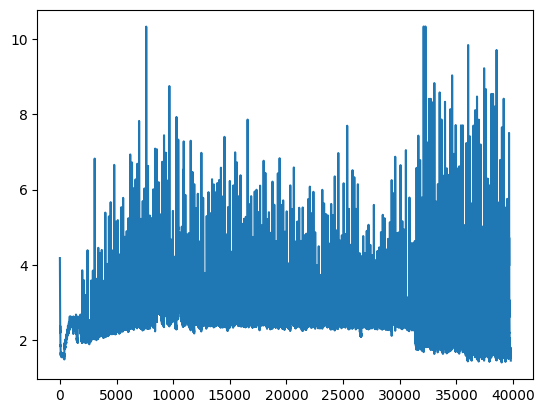

In [70]:
import glob
import json
from pathlib import Path
import matplotlib.pyplot as plt

# raw_losses = raw_loss_log
SAVE_DIR = Path('checkpoints/distance/v5+conv+curr+4lr')
latest_checkpoint_number = max([
  int(Path(path).name[len('check'):][:-len('.pt')]) for path in glob.glob('*.pt', root_dir=SAVE_DIR)
], default=-1)
raw_losses = []
for checkpoint_number in range(latest_checkpoint_number + 1):
  with open(SAVE_DIR / f'stats{checkpoint_number}.json', 'r') as f:
    train_stats = json.load(f)
  raw_losses.extend(train_stats['loss_log'])

plt.plot(raw_losses)
plt.show()

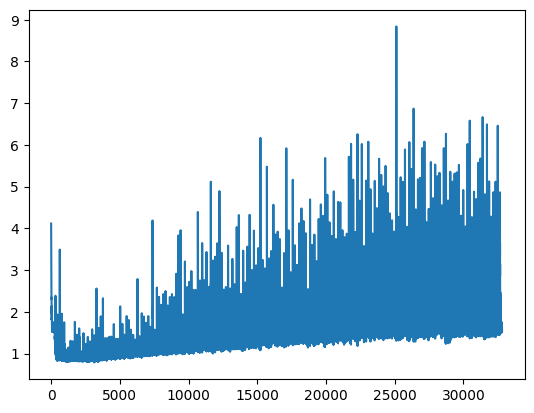

In [18]:
import glob
import json
from pathlib import Path
import matplotlib.pyplot as plt

# raw_losses = raw_loss_log
SAVE_DIR = Path('checkpoints/distance/v6-slowcurr')
latest_checkpoint_number = max([
  int(Path(path).name[len('check'):][:-len('.pt')]) for path in glob.glob('*.pt', root_dir=SAVE_DIR)
], default=-1)
raw_losses = []
for checkpoint_number in range(latest_checkpoint_number + 1):
  with open(SAVE_DIR / f'stats{checkpoint_number}.json', 'r') as f:
    train_stats = json.load(f)
  raw_losses.extend(train_stats['loss_log'])

plt.plot(raw_losses)
plt.show()

In [71]:
with torch.no_grad():
  errors = []
  actual = []
  predicted = []
  for image1, image2, distance in tqdm(testloader, desc=f'Testing'):
    image1 = image1.to(device)
    image2 = image2.to(device)

    latents = vae.encode(torch.cat((image1, image2), dim=0))
    latent1, latent2 = latents[:image1.shape[0]], latents[image1.shape[0]:]
    x = torch.cat((latent1, latent2), dim=1).to(device)
    x = x.detach()

    y = distance.to(device).round().clamp(0, 63).to(dtype=torch.long)
    
    prediction = distance_predictor(x)
    errors.append(prediction.argmax(-1) - distance.to(device))
    actual.append(distance)
    predicted.append(prediction.argmax(-1))
  errors = torch.cat(errors)
  print(errors.mean(), errors.std())

Testing: 100%|██████████| 16/16 [01:57<00:00,  7.35s/it]

tensor(-1.8151, device='cuda:0') tensor(19.0613, device='cuda:0')


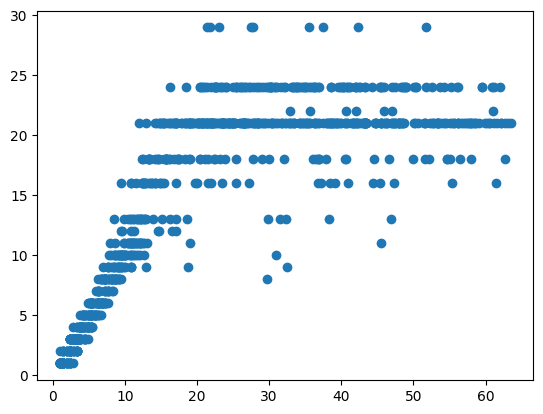

In [82]:
plt.scatter(torch.cat(actual).cpu(), torch.cat(predicted).cpu())

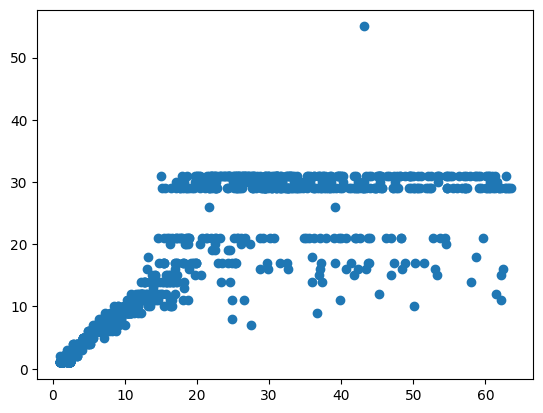

In [86]:
plt.scatter(torch.cat(actual).cpu(), torch.cat(predicted).cpu())

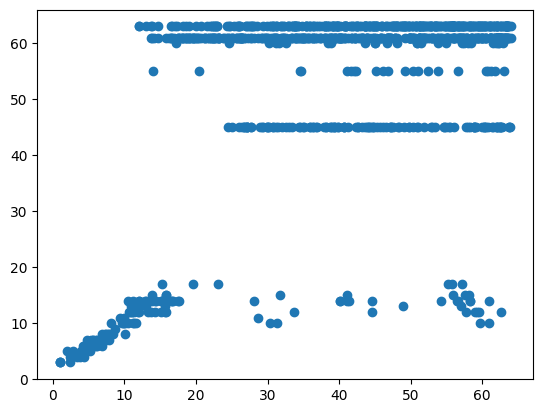

In [91]:
plt.scatter(torch.cat(actual).cpu(), torch.cat(predicted).cpu())

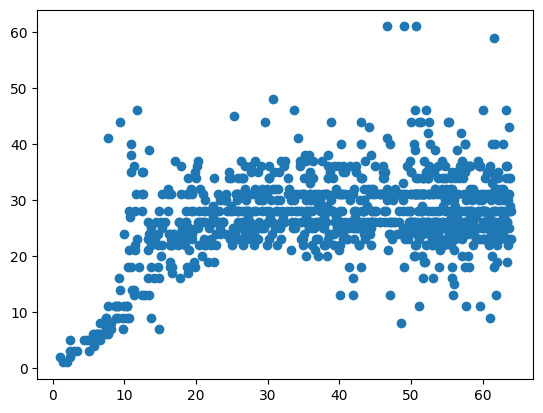

In [323]:
plt.scatter(torch.cat(actual).cpu(), torch.cat(predicted).cpu())

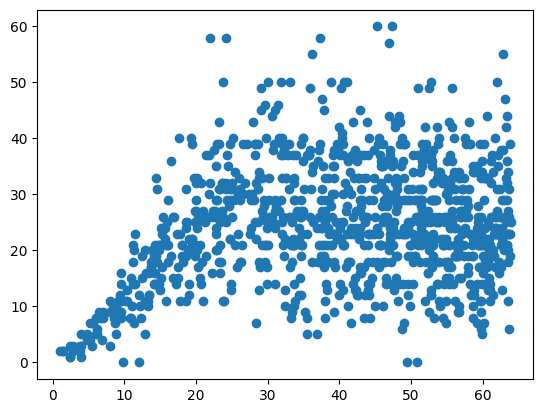

In [327]:
plt.scatter(torch.cat(actual).cpu(), torch.cat(predicted).cpu())

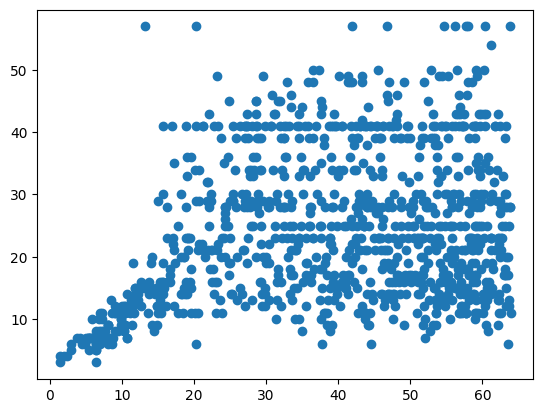

In [387]:
plt.scatter(torch.cat(actual).cpu(), torch.cat(predicted).cpu())

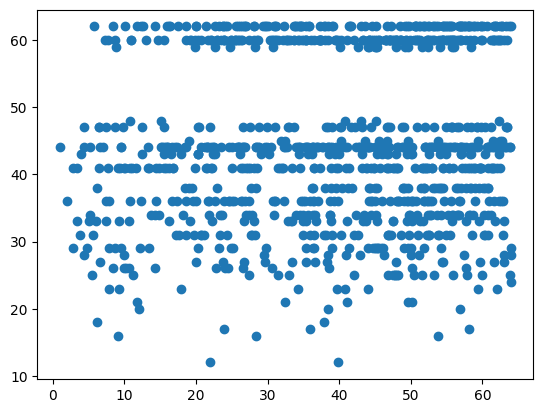

In [405]:
plt.scatter(torch.cat(actual).cpu(), torch.cat(predicted).cpu())

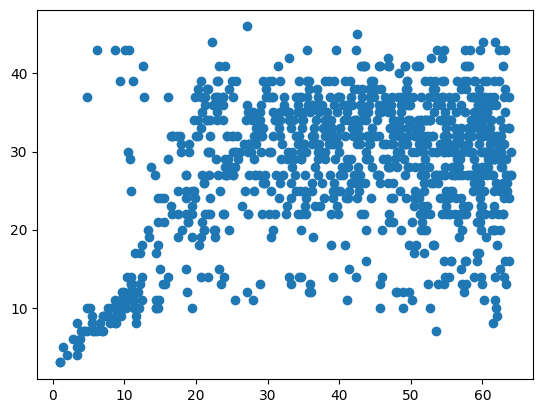

In [427]:
filter_points = torch.cat(actual).cpu() <= 64
plt.scatter(torch.cat(actual).cpu()[filter_points], torch.cat(predicted).cpu()[filter_points])

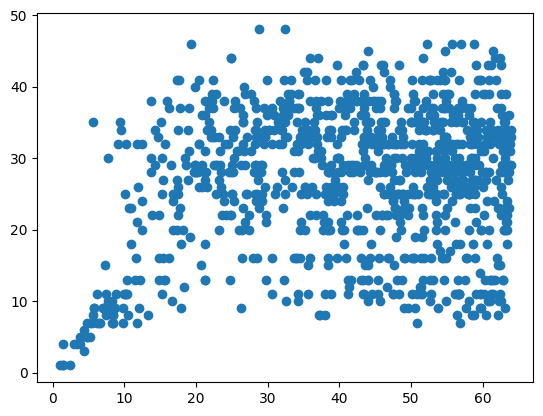

In [438]:
filter_points = torch.cat(actual).cpu() <= 64
plt.scatter(torch.cat(actual).cpu()[filter_points], torch.cat(predicted).cpu()[filter_points])

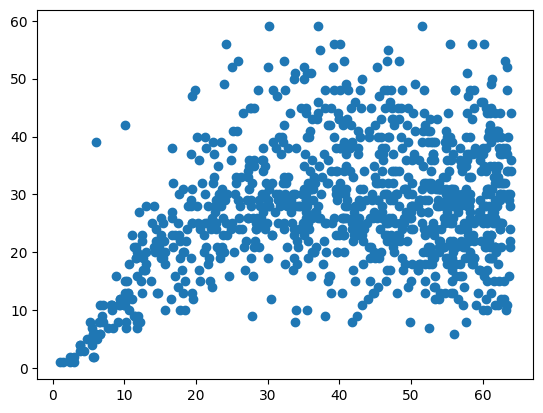

In [14]:
filter_points = torch.cat(actual).cpu() <= 64
plt.scatter(torch.cat(actual).cpu()[filter_points], torch.cat(predicted).cpu()[filter_points])

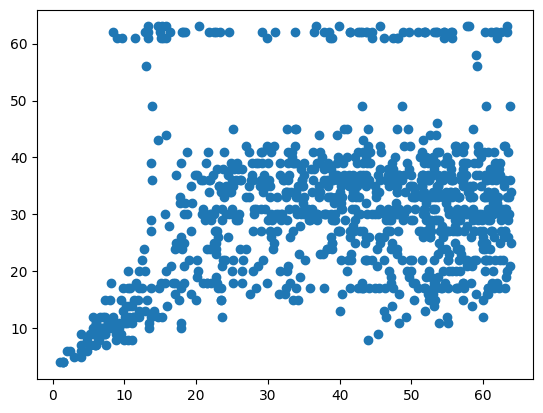

In [36]:
filter_points = torch.cat(actual).cpu() <= 64
plt.scatter(torch.cat(actual).cpu()[filter_points], torch.cat(predicted).cpu()[filter_points])

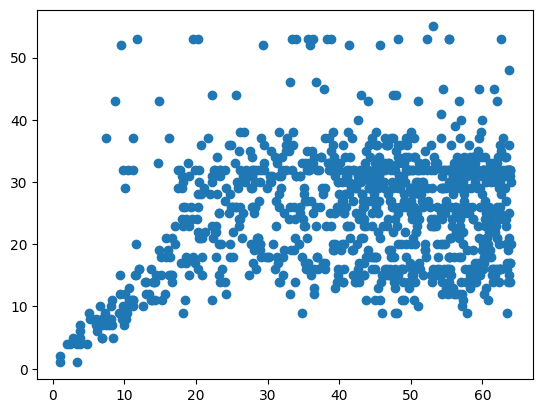

In [68]:
filter_points = torch.cat(actual).cpu() <= 64
plt.scatter(torch.cat(actual).cpu()[filter_points], torch.cat(predicted).cpu()[filter_points])

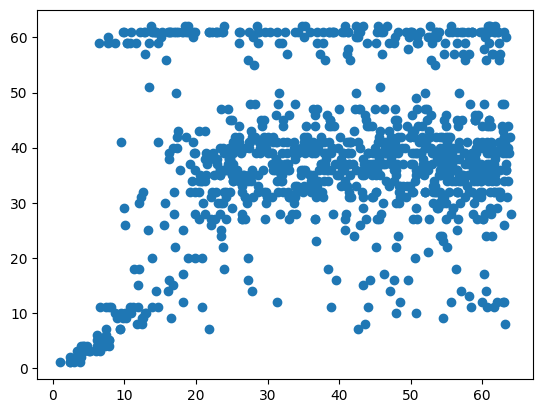

In [72]:
filter_points = torch.cat(actual).cpu() <= 64
plt.scatter(torch.cat(actual).cpu()[filter_points], torch.cat(predicted).cpu()[filter_points])

In [19]:
with torch.no_grad():
  errors = []
  actual = []
  predicted = []
  for image1, image2, distance in tqdm(testloader, desc=f'Testing'):
    image1 = image1.to(device)
    image2 = image2.to(device)

    latents = vae.encode(torch.cat((image1, image2), dim=0))
    latent1, latent2 = latents[:image1.shape[0]], latents[image1.shape[0]:]
    x = torch.cat((latent1, latent2), dim=1).to(device)
    x = x.detach()

    y = distance.to(device).round().clamp(0, 63).to(dtype=torch.long)
    
    prediction = distance_predictor(x)
    errors.append(prediction.argmax(-1) - distance.to(device))
    actual.append(distance)
    predicted.append(prediction)
  errors = torch.cat(errors)
  print(errors.mean(), errors.std())

Testing: 100%|██████████| 16/16 [01:39<00:00,  6.21s/it]

tensor(-9.1286, device='cuda:0') tensor(15.5220, device='cuda:0')


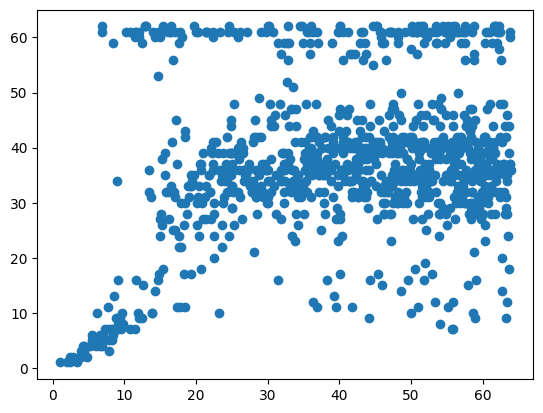

In [96]:
softmaxed = [(pred.softmax(-1).cpu() * torch.arange(64)).sum(-1, keepdim=True) for pred in predicted]
argmaxed = [pred.argmax(-1).cpu() for pred in predicted]
# print(len(softmaxed))
filter_points = torch.cat(actual).cpu() <= 64
plt.scatter(torch.cat(actual).cpu()[filter_points], torch.cat(argmaxed)[filter_points])

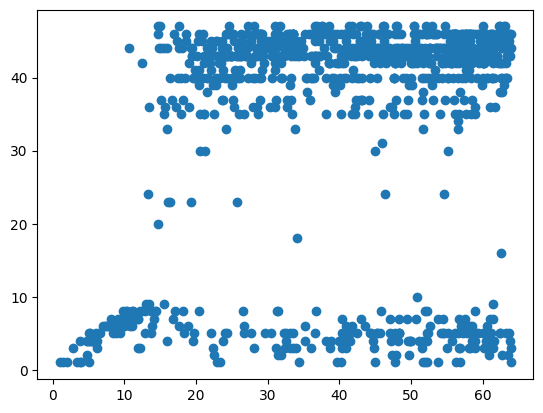

In [15]:
softmaxed = [(pred.softmax(-1).cpu() * torch.arange(64)).sum(-1, keepdim=True) for pred in predicted]
argmaxed = [pred.argmax(-1).cpu() for pred in predicted]
# print(len(softmaxed))
filter_points = torch.cat(actual).cpu() <= 64
plt.scatter(torch.cat(actual).cpu()[filter_points], torch.cat(argmaxed)[filter_points])

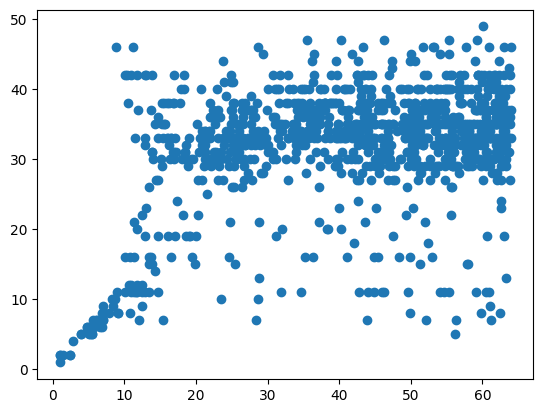

In [20]:
softmaxed = [(pred.softmax(-1).cpu() * torch.arange(64)).sum(-1, keepdim=True) for pred in predicted]
argmaxed = [pred.argmax(-1).cpu() for pred in predicted]
# print(len(softmaxed))
filter_points = torch.cat(actual).cpu() <= 64
plt.scatter(torch.cat(actual).cpu()[filter_points], torch.cat(argmaxed)[filter_points])

In [489]:
import matplotlib.pyplot as plt
state = Topo.random()
start_time = time.perf_counter()
path = shortest_path(state, np.array([128, 128]), np.array([100, 120]))
while path is None:
  state = Topo.random()
  path = shortest_path(state, np.array([128, 128]), np.array([100, 120]))
print(time.perf_counter() - start_time)
path

0.01288389999535866


([array([128, 128]),
  array([127, 127]),
  array([126, 126]),
  array([125, 125]),
  array([124, 124]),
  array([123, 123]),
  array([122, 122]),
  array([121, 121]),
  array([120, 120]),
  array([119, 119]),
  array([118, 118]),
  array([117, 117]),
  array([116, 116]),
  array([115, 115]),
  array([114, 114]),
  array([113, 113]),
  array([112, 113]),
  array([111, 112]),
  array([110, 112]),
  array([109, 112]),
  array([108, 112]),
  array([107, 113]),
  array([106, 114]),
  array([105, 115]),
  array([104, 116]),
  array([103, 117]),
  array([102, 118]),
  array([101, 119]),
  array([100, 120], dtype=uint32)],
 np.float64(37.941125496954285))

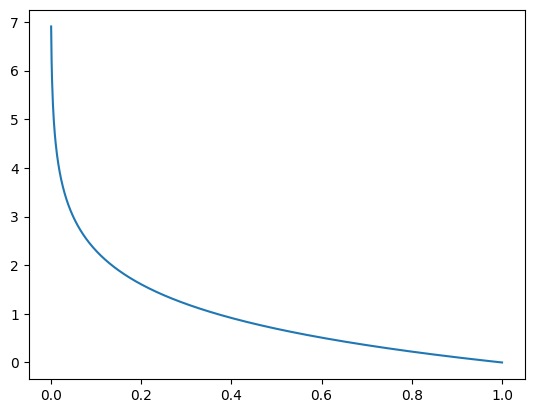

In [6]:
import matplotlib.pyplot as plt
z = np.linspace(0.001, 1, 1000)
plt.plot(z, -np.log(z)) 